# Controllers

Optimal control solves the Markov decision process (MDP) for continuous spaces.  Sia uses finite horizon model predictive control (MPC), which is a practical runtime solution to accomplish this.  The objective is modeled as total cost $J(x, U)$ comprised of running $c_i$ and final costs $c_f$ for the sequence of actions $U = \{u_0, \ldots, u_{T-1}\}$

$$
J(x,U) = c_f(x_T) + \sum_{i=0}^{T-1} c_i(x_i,u_i)
$$

This cost structure is general enough to define a moving window cost around a trajectory.  The optimal controller finds the optimal sequence of actions $U$ from the current time to a horizon of $T$ steps into the future by solving

\begin{gather}
U^* = \arg\min_U~J(x, U) \\
\text{s.t.}~x_{k+1} = f(x_k, u_k)
\end{gather}

The first action $u_0$ in the sequence $U$ is applied to the system at the current time step.  Measurements are collected, state estimates are performed (if needed), and the optimal control problem is solved again on the next time step.

In Sia, cost functions inherit from the `sia.CostFunction` virtual base class which defines the generic cost structure above.  Concrete functional (differentiable) and quadratic cost specializations are provided.  Controllers inherit from the `sia.Controller` virtual base class which defines a generic `policy()` method to compute an action given the current state.  Sia includes several MPC algorithms, outlined in the table below.  Note that models in parenthesis are implicitly supported due to model inheritance.   Also note that both discrete time and continuous time model variants are supported.

| Controller | Optimal  | Supported costs                                 | Supported dynamics models                                                        |
| ---------- | -------- | ----------------------------------------------- |--------------------------------------------------------------------------------- |
| LQR        | Yes      | QuadraticCost                                   | LinearGaussianDynamics                                                           |
| ILQR       | No       | FunctionalCost, QuadraticCost               | LinearizableDynamics (NonlinearGaussianDynamics, LinearGaussianDynamics)         |
| MPPI       | No       | CostFunction, FunctionalCost, QuadraticCost | DynamicsModel (LinearizableDynamics, NonlinearGaussianDynamics, LinearGaussianDynamics) |

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

**Example**

We'll build controllers that collide two 2nd order moving particles $a$ and $b$ on a 2D plane.  Particle $a$ is controlled while particle $b$ is on a free trajectory.

$$
\begin{array}{cc}
\text{Particle a} & \text{Particle b} \\
\dot{v}_a = u,   & \dot{v}_b = 0 \\
\dot{x}_a = v_a, & \dot{x}_b = v_b
\end{array}
$$

We can represent this system with the linear state equations

$$
\begin{pmatrix}
\dot{v}_a \\
\dot{x}_a \\
\dot{v}_b \\
\dot{x}_b
\end{pmatrix} = \begin{pmatrix}
0 & 0 & 0 & 0 \\
I & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & I & 0
\end{pmatrix} \begin{pmatrix}
v_a \\
x_a \\
v_b \\
x_b
\end{pmatrix} + \begin{pmatrix}
1 \\
0 \\
0 \\
0 
\end{pmatrix} u
$$

We'll denote the state $x = (v_a,x_a,v_b,x_b)^\top$.  The objective of the controller is to drive the system to $x_a = x_b$, i.e. $\min \|x_a - x_b\|^2$.  We can accomplish this by minimizing the quadratic cost

$$
J(x,u) = q \begin{pmatrix}
x_a & x_b 
\end{pmatrix} \begin{pmatrix}
I & -I \\
-I & I
\end{pmatrix} \begin{pmatrix}
x_a \\ x_b 
\end{pmatrix} + r u^\top u
$$

In [2]:
# System
dt = 0.1
A = np.zeros((8, 8))
A[2:4,0:2] = np.eye(2)
A[6:8,4:6] = np.eye(2)
B = np.zeros((8, 2))
B[0:2,0:2] = np.eye(2)
I = np.eye(8)
system = sia.LinearGaussianDynamicsCT(A, B, I, dt)

# Cost
Q = np.zeros((8, 8))
Q[2:4,2:4] = np.eye(2)
Q[2:4,6:8] = -np.eye(2)
Q[6:8,2:4] = -np.eye(2)
Q[6:8,6:8] = np.eye(2)
Qf = Q
R = np.eye(2)

# We'll make the running and final cost tunable normalized to the action cost
q = 0    # Running cost
qf = 100  # Final cost
cost = sia.QuadraticCost(qf * Q, q * Q, R)

## Linear Quadratic Regulator (LQR)

LQR solves the optimal control problem for a linear system $x_{k+1} = F x_k + G u_k$ and quadratic cost.

$$
J_i = \frac{1}{2} (x_T-x^*_T)^\top Q_f (x_T-x^*_T) + \sum_{i=0}^{T-1} (x_i-x^*_i)^\top Q (x_i-x^*_i) + u^\top R u
$$

1. In the backward recursion step the terminal cost is used to initialize the value function gradient $v_{T-1} = Q_f x^*_T$ and Hessian $P_{T-1} = Q_f$.  The feedback and feedforward gains $K,k$ are then computed.  The value function gradient $v$ and Hessian $P$ are back propogated using the Riccati equations.

\begin{gather}
Q_{uu}^{-1} = \left(R + G^\top P_{i+1} G\right)^{-1} \\
K_i = Q_{uu}^{-1} G^\top P_{i+1} F \\
k_i = Q_{uu}^{-1} G^\top v_{i+1} \\
P_i = F^\top P_{i+1} \left(F - G K_i\right) + Q \\
v_i = \left(F - G K_i\right)^\top v_{i+1} + Q_f x^*_i
\end{gather}

2. In the forward recursion step, the action and next state are computed.

\begin{gather}
u_i = - K_i x_i + k_i \\
x_{i+1} = F x_i + G u_i
\end{gather}

The tuning parameters with LQR are the cost matrices $Q_f, Q, R$ and the horizon $T$.  Increasing the state cost $Q_f, Q$ vs action cost $R$ reduces tracking error at the expense of higher amplitude actions.  The horizon $T$ is chosen to trade off runtime execution versus the ability to anticipate future dynamics.

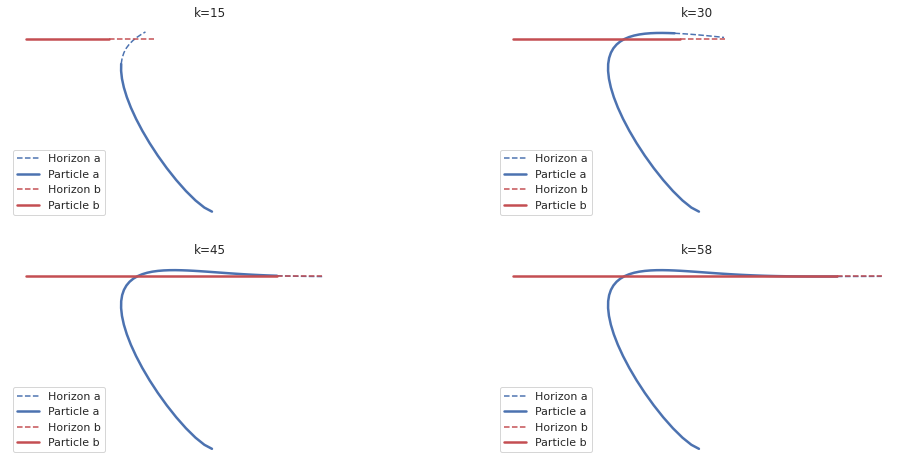

In [3]:
# Initialize the controller
horizon = 10
lqr = sia.LQR(system, cost, horizon)

# Initialize the system states
n = 60
u = np.zeros((2, n))
x = np.zeros((8, n))
x[:, 0] = np.array([-3, 0, 10, 0, 3, 0, 0, 8])
s = sia.Gaussian(8)

# Run the system for n steps
f, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
ax = ax.flatten()
sns.despine(f, left=True, bottom=True)
c = 0
for k in range(0, n-1):
    s.setMean(x[:, k])
    u[:, k] = lqr.policy(s)
    
    # Plot the system at several time slices
    if k == 15 or k == 30 or k == 45 or k == 58:
        states = np.array(lqr.states()).T
        ax[c].plot(states[2, :], states[3, :], '--b', lw=1.5, label="Horizon a")
        ax[c].plot(x[2, :k+1], x[3, :k+1], '-b', lw=2.5, label="Particle a")
        ax[c].plot(states[6, :], states[7, :], '--r', lw=1.5, label="Horizon b")
        ax[c].plot(x[6, :k+1], x[7, :k+1], '-r', lw=2.5, label="Particle b")
        ax[c].set_title("k={}".format(k))
        ax[c].legend(loc="lower left")
        ax[c].axis("off")
        c += 1
    
    x[:, k+1] = system.f(x[:, k], u[:, k])

## Iterative Linear Quadratic Regulator (iLQR)

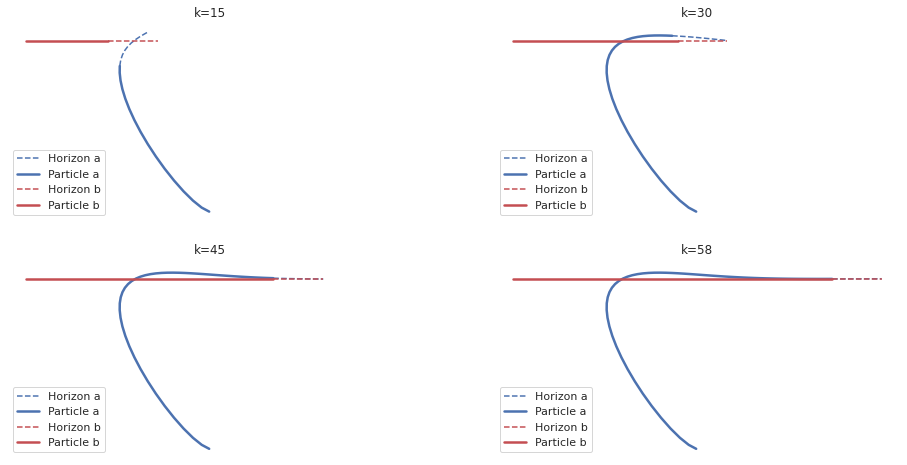

In [4]:
# Initialize the controller
horizon = 10
u0 = [np.array([0, 0]) for i in range(horizon)]
ilqr = sia.iLQR(system, cost, u0, max_iter=10, max_backsteps=10)

# Initialize the system states
n = 60
u = np.zeros((2, n))
x = np.zeros((8, n))
x[:, 0] = np.array([-3, 0, 10, 0, 3, 0, 0, 8])
s = sia.Gaussian(8)

# Run the system for n steps
f, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
ax = ax.flatten()
sns.despine(f, left=True, bottom=True)
c = 0
for k in range(0, n-1):
    s.setMean(x[:, k])
    u[:, k] = ilqr.policy(s)
    
    # Plot the system at several time slices
    if k == 15 or k == 30 or k == 45 or k == 58:
        states = np.array(ilqr.states()).T
        ax[c].plot(states[2, :], states[3, :], '--b', lw=1.5, label="Horizon a")
        ax[c].plot(x[2, :k+1], x[3, :k+1], '-b', lw=2.5, label="Particle a")
        ax[c].plot(states[6, :], states[7, :], '--r', lw=1.5, label="Horizon b")
        ax[c].plot(x[6, :k+1], x[7, :k+1], '-r', lw=2.5, label="Particle b")
        ax[c].set_title("k={}".format(k))
        ax[c].legend(loc="lower left")
        ax[c].axis("off")
        c += 1
    
    x[:, k+1] = system.f(x[:, k], u[:, k])

## Model Predictive Path Integrals (MPPI)

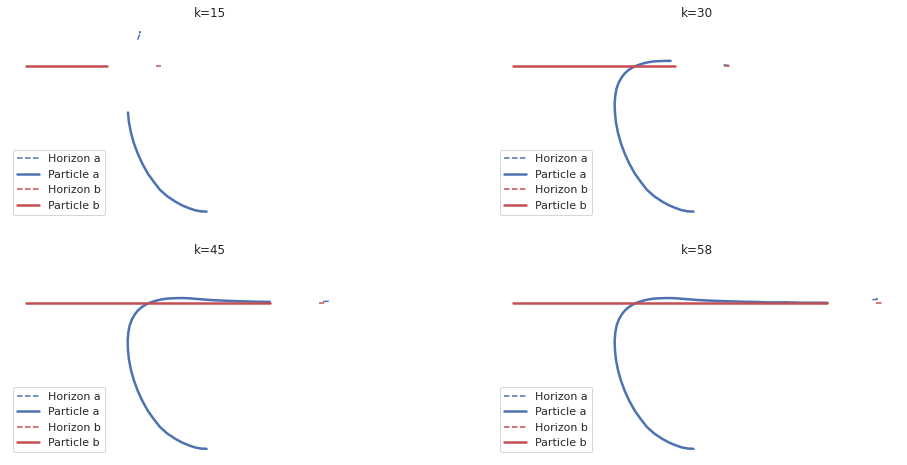

In [5]:
# Initialize the controller
horizon = 10
u0 = [np.array([0, 0]) for i in range(horizon)]
mppi = sia.MPPI(system, cost, u0, num_samples=1000, sigma=np.diag([1, 1]), lam=1e-1)

# Initialize the system states
n = 60
u = np.zeros((2, n))
x = np.zeros((8, n))
x[:, 0] = np.array([-3, 0, 10, 0, 3, 0, 0, 8])
s = sia.Gaussian(8)

# Run the system for n steps
f, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
ax = ax.flatten()
sns.despine(f, left=True, bottom=True)
c = 0
for k in range(0, n-1):
    s.setMean(x[:, k])
    u[:, k] = mppi.policy(s)
    
    # Plot the system at several time slices
    if k == 15 or k == 30 or k == 45 or k == 58:
        states = np.array(mppi.states()).T
        ax[c].plot(states[2, :], states[3, :], '--b', lw=1.5, label="Horizon a")
        ax[c].plot(x[2, :k+1], x[3, :k+1], '-b', lw=2.5, label="Particle a")
        ax[c].plot(states[6, :], states[7, :], '--r', lw=1.5, label="Horizon b")
        ax[c].plot(x[6, :k+1], x[7, :k+1], '-r', lw=2.5, label="Particle b")
        ax[c].set_title("k={}".format(k))
        ax[c].legend(loc="lower left")
        ax[c].axis("off")
        c += 1
    
    x[:, k+1] = system.f(x[:, k], u[:, k])